# Mapping charter schools

Authors: 
- Harshayu Girase, URAP research apprentice, Computer Science major, UC Berkeley
- Serena Jiang, URAP research apprentice, Computer Science major, UC Berkeley
- Jaren Haber, PhD Candidate, Sociology, UC Berkeley

In [7]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Point
import geopandas as gpd

In [8]:
# Define data file paths
charterfile = './charters_parsed_03-04_no-text_SMALL.csv'
districtfile = './ACS_2016_sd-merged_FULL.csv'
publicfile = './pub_merged_2015_acs.csv'
shapefile = 'district.shp'

district = gpd.read_file(shapefile) # Create shapefile DF with only geometric data (for general use)

## Define helper functions

In [16]:
def refresh_data():
    '''Loads data from file, undoing any bounding boxes, etc. 
    Great for making a fresh start when plotting a new area.
    
    Also merges geometric data from shapefile DF into full school district DF.
    To do this, first creates a common identifier across these DFs by modifying district 'Qualifying Name' 
    so it lines up with the district shapefile.'''
    
    global charterDF, district_df, publicDF
    
    # Import data:
    charterDF = pd.read_csv(charterfile, low_memory=False) # Charter school data
    publicDF = pd.read_csv(publicfile, low_memory=False) # Public school data
    districtDF = pd.read_csv(districtfile, encoding='latin-1', low_memory=False) # School district data
    
    # Merge shapefile with district file:
    districtDF['NAME'] = districtDF['Qualifying Name'].apply(lambda x: ",".join(x.split(",")[:-1]).strip())
    district_df = pd.merge(districtDF, district, on="NAME") 
    district_df = gpd.GeoDataFrame(district_df)
    
    # Create geometry for charter schools:
    charterDF['geometry'] = charterDF[['LONGCODE', 'LATCODE']].apply(lambda row: Point(row["LONGCODE"], row["LATCODE"]), axis=1) # Use GeoPandas to create Point class for each school
    charterDF = gpd.GeoDataFrame(charterDF)
    charterDF.crs = {'init' :'epsg:4326'}
    charterDF = charterDF.to_crs(district.crs)

    # TO DO: Improve projection so it layers the multiple shapefiles into a single map--to get rid of blank/white spaces

In [9]:
def createBoundingBox(boundingBox):
    '''Pre-requisite function for creating maps within a bounded area or "boundingBox".
    This function accomplishes this by limiting the relevant DataFrames to only those data points
    located within the bounded area defined in the two points indicated in the function call. 
    This allows the plot() function to map the entire DF (which it is designed to do).
    
    Input is a list of four numbers: [upperleft longitude, upperleft latitude, lowerleft longitude, lowerleft latitude].
    No direct output--modifies DFs.'''
    
    global publicDF
    global charterDF
    global district_df
    
    ULLON = boundingBox[0]
    ULLAT = boundingBox[1]
    LRLON = boundingBox[2]
    LRLAT = boundingBox[3]
    
    publicDF = publicDF[publicDF['LON1516']>ULLON]
    publicDF= publicDF[publicDF['LAT1516']<ULLAT]
    publicDF = publicDF[publicDF['LON1516']<LRLON]
    publicDF = publicDF[publicDF['LAT1516']>LRLAT]
    charterDF = charterDF[charterDF['LONGCODE']>ULLON]
    charterDF = charterDF[charterDF['LATCODE']<ULLAT]
    charterDF = charterDF[charterDF['LONGCODE']<LRLON]
    charterDF = charterDF[charterDF['LATCODE']>LRLAT]

    validDistricts = "" # String of all districts within bounded area, appended one at a time
    
    # Iterate over publicDF, adding each valid district into string validDistricts:
    for index, row in publicDF.iterrows():
        try:
            validDistricts += str(int(publicDF["LEAID"][index])) + " " # Grab LEAIDs for valid districts, indexing by column and then row
        except Exception as e:
            continue

    dropList = []
    
    for index, row in district_df.iterrows():
        try:
            if ((str(int(district_df["FIPS"][index]))) not in validDistricts):
                dropList.append(index)
        except Exception as e:
            continue
            
    district_df = district_df.drop(dropList) # Drop districts not in bounding box
    
    return

In [10]:
def plot(district_col, whole=True, state="", ab=""):
    '''Maps school districts in given area as chloropleth map shaded by variable district_col, 
    showing points for schools based on latitude/longitude and ess_lean. 
    Points are shaded such that blue is lower in ess_lean and red is higher.
    
    The only required parameter is district_col, the variable/column by which to shade school districts. 
    If bounding boxes are being used, ignore the other parameters below. 
    Example function call: 
    plot('Median household income (In 2014 Inflation Adjusted Dollars')
    
    Other parameters:
    whole = whether or not to map entire country (Boolean). If False, need BOTH of the following:
    state = whether to map a particular state
    ab = single state abbreviation, e.g. FL
    
    Leaving 'whole' as False and giving a state will plot that state only;
    Leaving 'whole' as False and giving no state will plot the whole US.
    
    Note on working with these functions:
    To use the single-state functionality of this function AFTER creating a bounding box, 
    rerun the notebook in order to recreate the full dataframes.'''
    
    
    figsize = (14, 7) if whole else (10,7) # Define scale for US (if whole) or single state (if not)
    fig, ax = plt.subplots(figsize=figsize)
    tempdistrict_df = district_df # Make temporary DF for within function
    
    # If mapping just one state, define state abbreviation column name:
    if not whole:
        tempdistrict_df = tempdistrict_df[tempdistrict_df['State/U.S.-Abbreviation (USPS)'] == ab]
        
    tempdistrict_df = tempdistrict_df[[district_col, 'geometry']].dropna() # Drop if no coordinates
    tempdistrict_df[district_col] = tempdistrict_df[district_col].apply(pd.to_numeric,downcast='float') # Convert to most efficient float type
    
    # Plot layers of map:
    tempdistrict_df.plot(ax = ax, column=district_col, cmap='PiYG', linewidth=0, legend=True) # Plot shaded areas
    charterDF[whole | (charterDF['STATENAME'] == state)].plot(ax = ax, cmap="coolwarm", column="ess_lean", markersize=20, linewidth=0, legend=True) # Plot points
    # Note: cmap = shading style (e.g., PiYG = pink to green)
    
    ax.legend()
    plt.show()
    
    return

## Plotting

In [17]:
refresh_data() # Load in data!

In [27]:
# Example of using mapping function:
bayArea = [-123.26482826886195, 38.66436310541212, -121.06756264386195, 37.12821658249273]
createBoundingBox(bayArea)
district_df

,FIPS,Name of Area,Qualifying Name,State/U.S.-Abbreviation (USPS),Summary Level,Geographic Component,File Identification,Logical Record Number,US,Region,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GISJOIN,Shape_Leng,Shape_Area,% Total Po,geometry
1453,0600019,"Dublin Unified School District, California","Dublin Unified School District, California",ca,970,00,ACSSF,0040098,NaN,NaN,...,E,35426071.0,0.0,+37.7153770,-121.9104967,G06000019,37799.106445,3.542606e+07,51.76,"(POLYGON ((-2235995.2443 329544.7997999992, -2..."
1454,0600020,"Pleasanton Unified School District, California","Pleasanton Unified School District, California",ca,970,00,ACSSF,0040099,NaN,NaN,...,E,102460910.0,391116.0,+37.6649739,-121.8867095,G06000020,58631.121814,1.028520e+08,94.96,"POLYGON ((-2229697.0096 327679.7281999998, -22..."
1455,0600021,"Sunol Glen Unified School District, California","Sunol Glen Unified School District, California",ca,970,00,ACSSF,0040100,NaN,NaN,...,E,244322988.0,2809642.0,+37.5511338,-121.8054596,G06000021,76479.473027,2.471326e+08,80.49,POLYGON ((-2228584.443600001 317234.8045000006...
1465,0600034,"Windsor Unified School District, California","Windsor Unified School District, California",ca,970,00,ACSSF,0040110,NaN,NaN,...,E,79504355.0,477276.0,+38.5491930,-122.8050545,G06000034,52828.730908,7.998163e+07,76.75,"POLYGON ((-2280226.1634 445700.2112000007, -22..."
1467,0600036,"Natomas Unified School District, California","Natomas Unified School District, California",ca,970,00,ACSSF,0040112,NaN,NaN,...,E,95948245.0,2823304.0,+38.6670737,-121.5671691,G06000036,54828.306707,9.877155e+07,45.17,POLYGON ((-2175513.788799999 428829.7045000009...
1474,0600044,"Healdsburg Unified School District, California","Healdsburg Unified School District, California",ca,970,00,ACSSF,0040119,NaN,NaN,...,E,145770119.0,345713.0,+38.6373850,-122.8884599,G06000044,78342.842100,1.461159e+08,76.54,"POLYGON ((-2284174.1231 457923.0056999996, -22..."
1477,0600047,"Tracy Unified School District, California","Tracy Unified School District, California",ca,970,00,ACSSF,0040122,NaN,NaN,...,E,504938787.0,27600762.0,+37.8910619,-121.4707749,G06000047,163699.130232,5.316333e+08,60.11,(POLYGON ((-2194139.802200001 359195.215800000...
1497,0601332,"Twin Rivers Unified School District, California","Twin Rivers Unified School District, California",ca,970,00,ACSSF,0040142,NaN,NaN,...,E,114082153.0,1389497.0,+38.6727995,-121.3842225,G06001332,89683.692314,1.154717e+08,57.54,"(POLYGON ((-2167406.512 419634.0886000004, -21..."
1500,0601410,"Lammersville Joint Unified School District, Ca...","Lammersville Joint Unified School District, Ca...",ca,970,00,ACSSF,0040145,NaN,NaN,...,E,60842581.0,69569.0,+37.7460948,-121.5230350,G06001410,36837.286594,6.091217e+07,40.11,"POLYGON ((-2201557.5886 333380.8332000002, -22..."
1506,0601770,"Alameda City Unified School District, California","Alameda City Unified School District, California",ca,970,00,ACSSF,0040152,NaN,NaN,...,E,27045458.0,32778370.0,+37.7419107,-122.2599139,G06001770,48864.867584,2.722580e+07,49.11,(POLYGON ((-2262129.186799999 342248.051699999...


In [18]:
refresh_data() # Refresh data and undo Bay Area bounding box

# Remove outliers using ess_lean:
charterDF['ess_lean'] = charterDF['ess_strength'] - charterDF['prog_strength']
charterDF = charterDF.dropna(subset=["ess_lean"])
high = charterDF['ess_lean'].quantile(.98) # Find upper limit of ess_lean (a number)
low = charterDF['ess_lean'].quantile(.02)
charterDF = charterDF[(charterDF['ess_lean'] < high) & (charterDF['ess_lean'] > low)]

/Users/harshayugirase/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


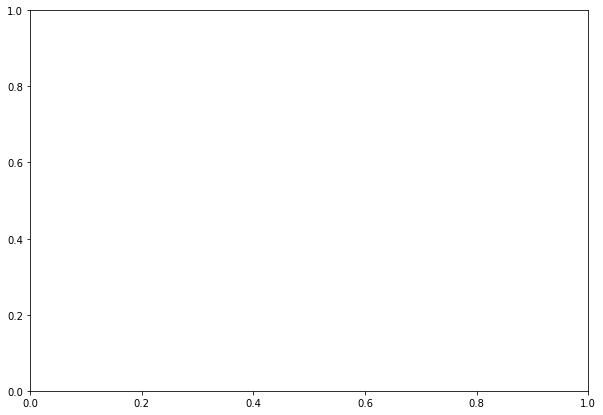

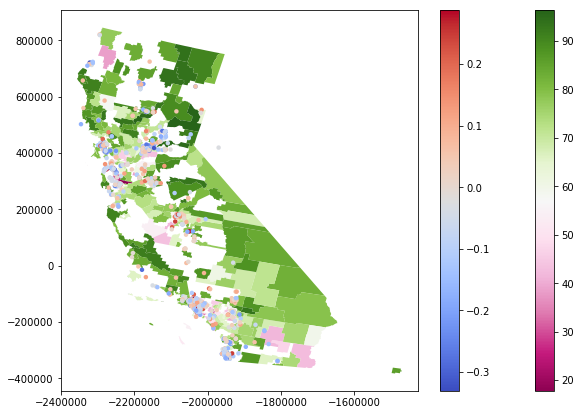

In [21]:
plot('% Total Population: White Alone', False, 'CALIFORNIA', 'ca') 

/Users/harshayugirase/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


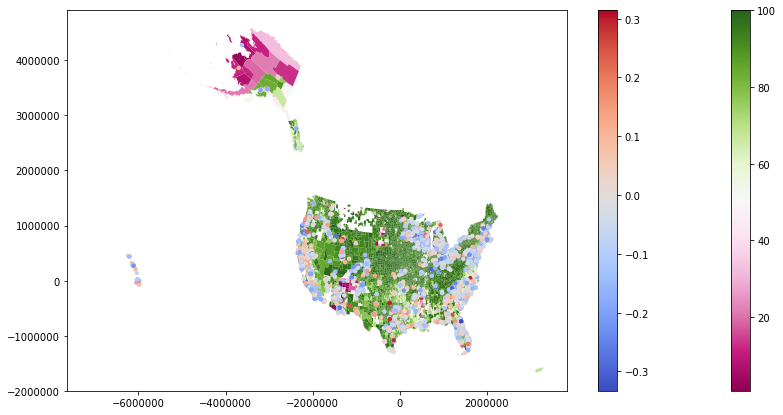

In [22]:
plot('% Total Population: White Alone')

/Users/harshayugirase/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


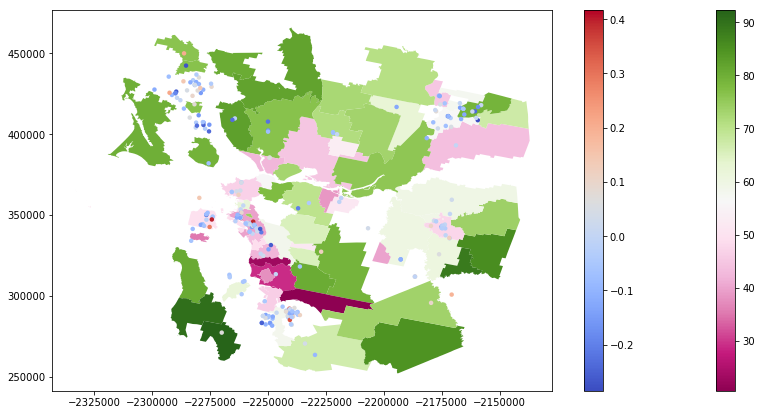

In [38]:
plot('% Total Population: White Alone')

/Users/harshayugirase/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


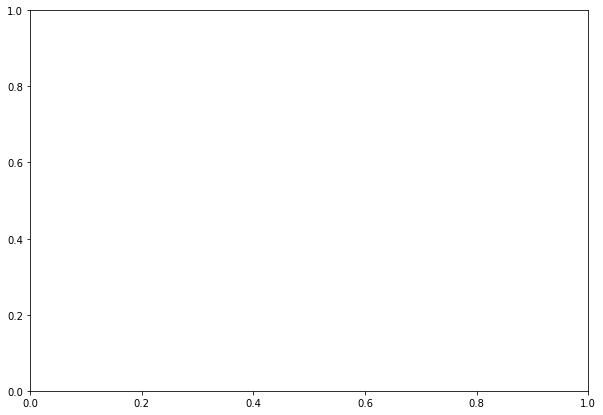

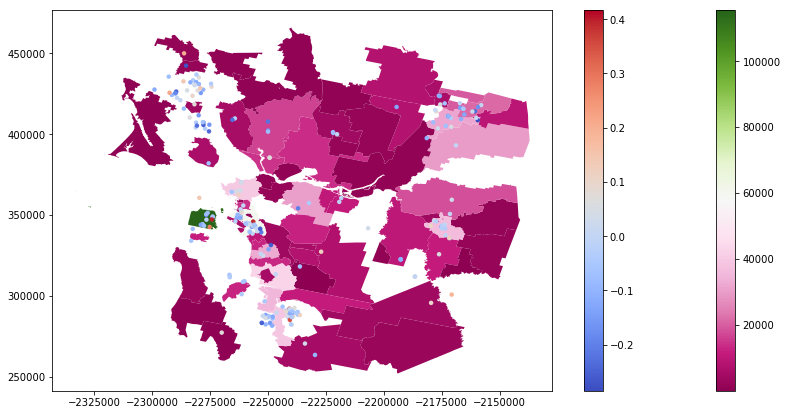

In [40]:
plot('Total Population: Foreign Born: Not a Citizen')